# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

Our goal in this project is to examine this dataset of job postings, and predict salaries for a new set of postings. This will involve building a model to predict the salaries given in the test dataset.

A practical use of this is for a HR Department of a large company or a Consulting Outfit that needs real-time solutions in order to make effective employment offers to potential hires. 

It also finds use in getting to understand current realities in the job market and how businesses can leverage this in order to secure high quality talent, whilst keeping hiring costs low.

The primary tool used for this project is Python 3, along with an extensive array of libraries and packages available for the manipulation of data,and development of predictive modeling algorithms.

This Project is broken down into the following Sections:

#### Defining the Problem

#### Creating "Data" and "Plots" classes and objects to aid us in extracting, manipulating the given data

#### Exploratory Data Analysis
This involves looking at the Data Summaries and Visualizations in order to:
1. Examine the Data
2. Discover patterns and relationships between the features
3. Identify the types of data
4. Clean up the Data

#### Creating classes and objects for Feature Engineering, and Model Selection
This will help us preprocess and create new features from existing ones. Here we shall also select the best model for prediction. The algorithms chosen for this are:

1. Linear Regression
2. Random Forest Regressor
3. Gradient Boosting Regressor

The Evaluation metric used for these models is the Mean Squared Error.

Also we shall look at the Feature Importances, and how each feature performs with the best model selected in making predictions.

#### Saving the results for Deployment


### Defining the problem

Our twofold goal in this project is to:
1. Load and Explore Data
2. Develop and train a suitable prediction model

In [1]:
#your info here
__author__ = "Ovo Okpubuluku"
__email__ = "ovo@live.ca"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
# Ignore deprecation warnings in sklearn
import warnings
warnings.filterwarnings('ignore')
import pickle

## Part 2 - DISCOVER

### Defining a Data Class for uploading datasets

In [3]:
class Data:
    def __init__(self, train_features, train_target, test_features, target_col):
        '''loading dataframes'''
        self.train_features = train_features
        self.train_target = train_target
        self.test_features = test_features
        self.target_col = target_col
        self.process_data()
        
    def process_data(self):
        self._create_train_df()
        self._create_test_df()
        self._column_info()
        self._print_trainstats()
        self._print_teststats()
        self._flag_invalids(self.train_df, self.target_col)
        self._check_duplicates()
                  
       
    def _create_train_df(self):
        '''loads and prepares train dataframe'''
        train_feature_df = self._load_dataset(train_features)
        train_target_df = self._load_dataset(train_target)
        self.train_df = self._merge_df(train_feature_df, train_target_df)
        
    def _create_test_df(self):
        '''loads and encodes labels in test dataframe'''
        self.test_df = self._load_dataset(test_features)
        
    def _column_info(self):
        self.cat_cols = self._cat_cols(self.train_df)
        self.num_cols = self._num_cols(self.train_df)
        
    def _print_trainstats(self):
        print('  \n ----------Train Data Info---------')
        self.printstats(self.train_df)
        self._check_nan(self.train_df)
        
    def _print_teststats(self):
        print('  \n ----------Test Data Info---------')
        self.printstats(self.test_df)
        self._check_nan(self.test_df)
    
    def _load_dataset(self, file):
        return pd.read_csv(file)
    
    def _merge_df(self, df1, df2, key=None, left_index=False, right_index=False):
        return pd.merge(left=df1, right=df2, how='inner', on=key, left_index=left_index, right_index=right_index)
    
    def printstats(self, df):
        print('---------------------------------------------------------')
        print('Shape of Dataframe - {}'.format(df.shape))
        print('---------------------------------------------------------')
        print('\n Dataframe Info: \n')
        print('n{}'.format(df.info()))
        print('---------------------------------------------------------')
        print(' Numerical Features Stats: \n \n{}'.format(df.describe()))
        print('---------------------------------------------------------')
        print(' Categorical Features Stats: \n \n{}'.format(df.describe(include='O')))
              
    def _check_nan(self, df):
        '''Checks and verifies presence of null values in Dataframe'''
        nan = np.sum(df.isna().sum())
        if nan == 0:
            print('\n\n : There are no null values in the dataframe')
        else:
            print('The following columns have null values\n\n{}'.format(df.isnull().sum()))
              
    def _cat_cols(self, df):
        '''finds and lists Categorical Columns in Dataframe'''
        self.cat_cols = df.select_dtypes(include=['O']).columns.tolist()
        print('Categorical Columns list: {}'.format(self.cat_cols))
        print('---------------------------------------------------------')
        return self.cat_cols
              
    def _num_cols(self, df):
        '''finds and lists Numerical Columns in Dataframe'''
        self.num_cols = df.select_dtypes(exclude=['O']).columns.tolist()
        print('Numerical Columns list: {}'.format(self.num_cols))
        print('---------------------------------------------------------')
        return self.num_cols
              
    def _flag_invalids(self, df, cols):
        '''Finds and flags invalid values'''
        for col in [cols]:
            valcount = np.sum(df[col] <= 0)
            if valcount > 0:
                self.invalid_flag = True
                print('\n :  There are {} duplicate values in {} column'.format(valcount, col))
              
    def _check_duplicates(self):
        '''Checks presence of duplicate entries'''
        print('\n :  There are {} duplicate values in Train Data'.format(self.train_df.duplicated().sum()))
        print('\n : There are {} duplicate values in Test Data'.format(self.test_df.duplicated().sum()))

### Defining Plots class for creating visualizations to aid Data Exploration

In [4]:
class Plots:
    sns.set(style="darkgrid")
    
    def __init__(self, data):
        self.data = data
        self.train_df = data.train_df
        self.target_col = data.target_col
        self.cat_cols = data.cat_cols
        self.num_cols = data.num_cols
        self.corr_cols = ['companyId_mean', 'jobType_mean', 'degree_mean', 'major_mean', 'industry_mean', 'yearsExperience', 'milesFromMetropolis', 'salary']
        self.eda_process()
        
    def eda_process(self):
        self._distplot()
        self._boxplot()
        self._heatmap()
        
    def _distplot(self):
        '''Creates Distribution Plots for Numeric Features'''
        fig = plt.figure(figsize=(14, 14))
        for index, col in enumerate(self.num_cols):
            fig.add_subplot(len(self.num_cols), len(self.num_cols), index+1)
            sns.distplot(self.train_df[col], bins=20,color='g')
            plt.title('Distribution Plot')
            plt.tight_layout()
            
    def _boxplot(self):
        '''Creates Boxplots for both Categorical and Numerical Features'''
        df = self.train_df.copy()
        fig = plt.figure(figsize=(14, 18))
        for index, col in enumerate(self.cat_cols):
            if len(self.train_df[col].unique()) < 10:
                df[col + '_mean'] = df.groupby(col)[self.target_col].transform('mean')
                fig.add_subplot(3, 2, index+1)
                sns.boxplot(x=col, y=self.target_col, data=df.sort_values(col + '_mean'))
                plt.title('Salaries vs {}'.format(col), fontsize=12)
                plt.tight_layout()
                plt.xticks(rotation=45)
        for index, col in enumerate(self.num_cols):
            fig.add_subplot(len(self.num_cols), len(self.num_cols), index+1)
            sns.boxplot(self.train_df[col], color='r')
            plt.tight_layout()
    
                
    def _heatmap(self):
        '''Creates Heatmap showing Cross Correlation between variables'''
        df = self.train_df.copy()
        for col in self.cat_cols:
            if len(self.train_df[col].unique()) < 100:
                df[col + '_mean'] = df.groupby(col)[self.target_col].transform('mean')
        fig = plt.figure(figsize=(12, 10))
        sns.heatmap(df[self.corr_cols].corr(), cmap='Purples', annot=True)
        plt.tight_layout()
        plt.title('Heatmap', fontsize=16)
        plt.xticks(rotation=45)

In [5]:
#Defining Dataset locations for upload
train_features = './data/train_features.csv'
train_target = './data/train_salaries.csv'
test_features = './data/test_features.csv'
target_col = 'salary'

### Now, we upload the datasets using the Data class

Also we'll begin Exploration by:
1. Looking at the summary information of the Dataframe;
2. Check for null and duplicate values in the datasets;
3. Merge both train features and train target data into a single dataframe

In [6]:
data = Data(train_features, train_target, test_features, target_col)

Categorical Columns list: ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry']
---------------------------------------------------------
Numerical Columns list: ['yearsExperience', 'milesFromMetropolis', 'salary']
---------------------------------------------------------
  
 ----------Train Data Info---------
---------------------------------------------------------
Shape of Dataframe - (1000000, 9)
---------------------------------------------------------

 Dataframe Info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-n

In [9]:
data.train_df.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31,113
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24,178
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70,73
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54,31
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68,104


In [10]:
data.test_df.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44
5,JOB1362685407692,COMP40,CTO,MASTERS,COMPSCI,FINANCE,6,23
6,JOB1362685407693,COMP32,SENIOR,MASTERS,COMPSCI,SERVICE,6,32
7,JOB1362685407694,COMP11,CEO,BACHELORS,BIOLOGY,SERVICE,9,73
8,JOB1362685407695,COMP39,MANAGER,DOCTORAL,PHYSICS,HEALTH,6,78
9,JOB1362685407696,COMP22,VICE_PRESIDENT,NONE,NONE,AUTO,23,97


### Now we'll create visuals for further Exploratory Data Analysis by using the Plots class on the train dataframe

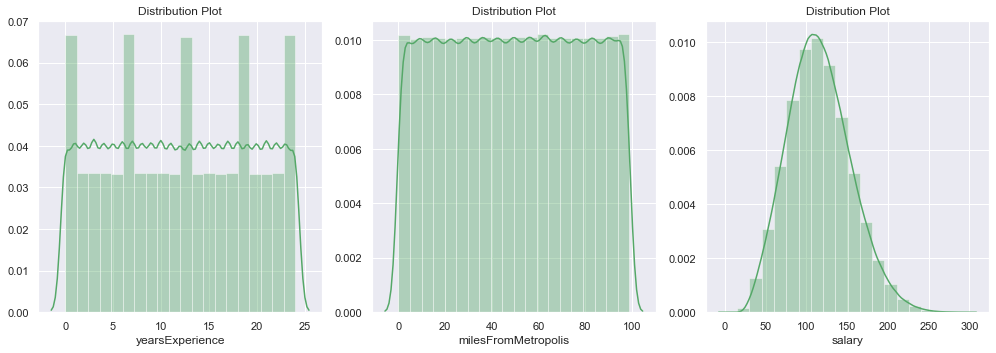

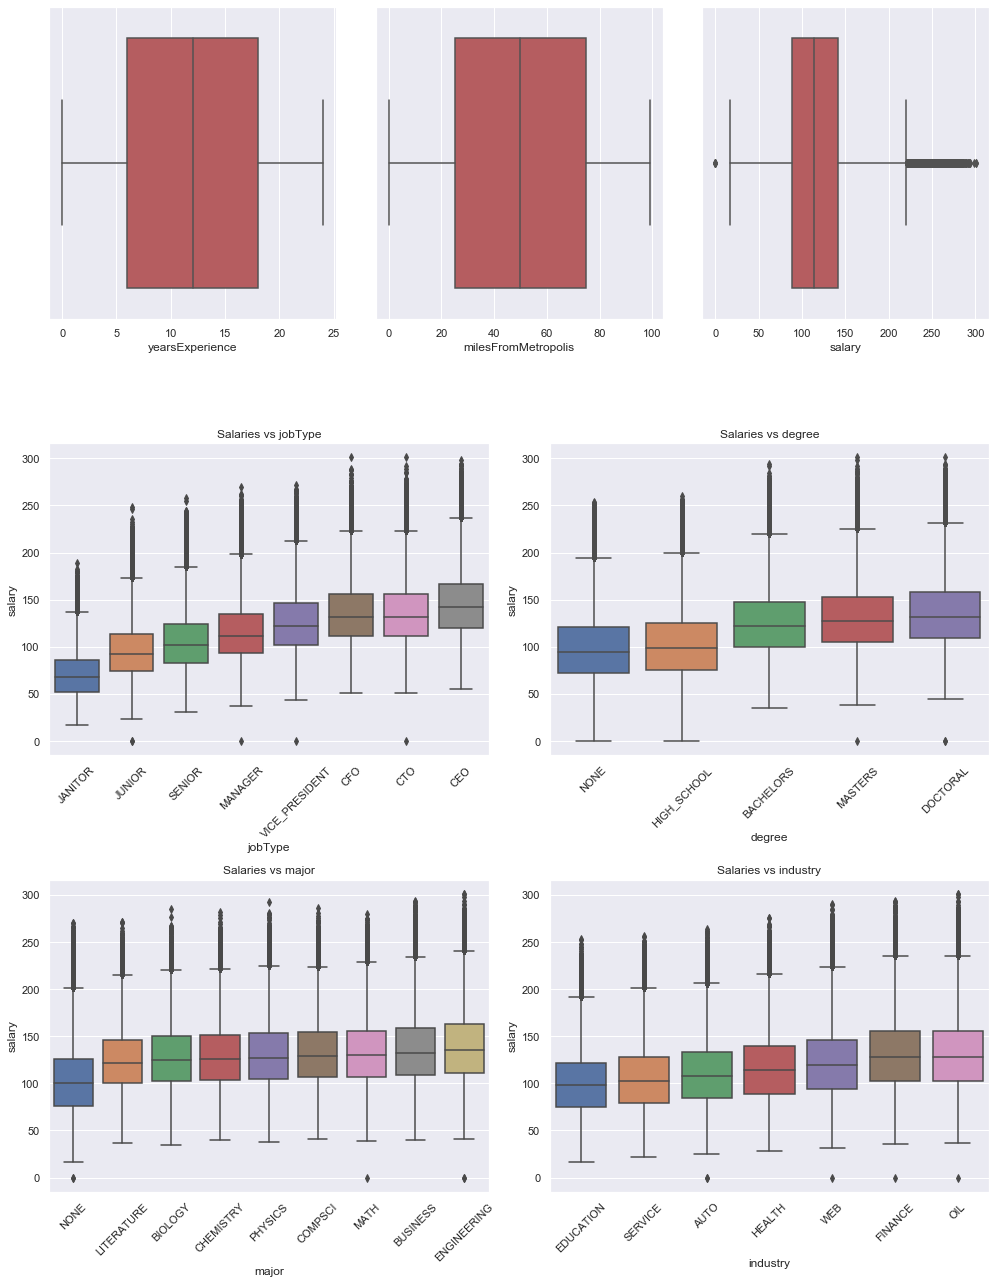

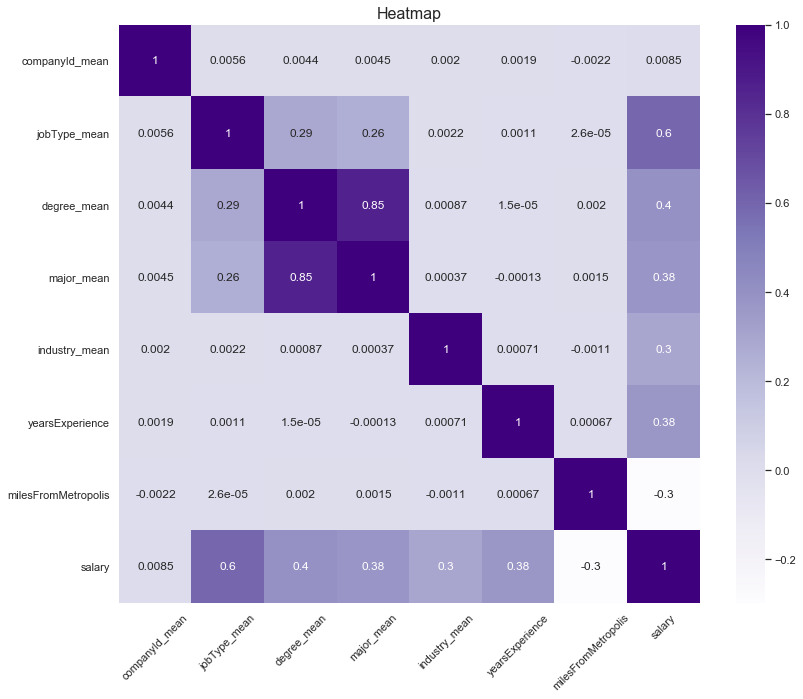

In [11]:
visuals = Plots(data)

From the Boxplots showing the categorical variables, we see that:

1. The Senior Job types obviously earn the highest salaries (Strong positive correlation)
2. Advanced Degrees tend to attract higher salaries
3. Engineering, Business, Math and Computer Science are on the top end of the salary continuum
4. The Oil and Finance Industries are the highest paying in the job market represented by this data

The trends spelt out above are corroborated in the Heatmap (Correlation Matrix), which shows jobtype as the most strongly correlated feature with salary. Degree and Major have the strongest positive relationship, understandably




### Examining the Target Variable (Salary)
We can easily identify the Salary Feature as the Target Variable. When we inspect the Salary Distribution Boxplot, we can see the existence of outliers. The lower outlier sits exactly on zero. We'll now use the IQR rule to identify these outlier values and then make our determination

In [13]:
stat = data.train_df.salary.describe()
print(stat)
IQR = stat['75%'] - stat['25%']
upper = stat['75%'] + 1.5 * IQR
lower = stat['25%'] - 1.5 * IQR
print('The upper and lower bounds for suspected outliers are {} and {}.'.format(upper, lower))

count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64
The upper and lower bounds for suspected outliers are 220.5 and 8.5.


We will now examine the Salary values below 8,500 and greater than 220,500 and determine if those values are realistic.

In [14]:
data.train_df[data.train_df.salary < 8.5]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [17]:
data.train_df[data.train_df.salary > 220.5]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
266,JOB1362684407953,COMP30,CEO,MASTERS,BIOLOGY,OIL,23,60,223
362,JOB1362684408049,COMP38,CTO,MASTERS,NONE,HEALTH,24,3,223
560,JOB1362684408247,COMP53,CEO,MASTERS,BIOLOGY,WEB,22,7,248
670,JOB1362684408357,COMP26,CEO,MASTERS,MATH,AUTO,23,9,240
719,JOB1362684408406,COMP54,VICE_PRESIDENT,DOCTORAL,BIOLOGY,OIL,21,14,225
...,...,...,...,...,...,...,...,...,...
998516,JOB1362685406203,COMP29,CFO,MASTERS,ENGINEERING,WEB,14,46,227
999249,JOB1362685406936,COMP30,CEO,NONE,NONE,OIL,17,10,223
999280,JOB1362685406967,COMP2,CFO,BACHELORS,BUSINESS,SERVICE,21,0,228
999670,JOB1362685407357,COMP20,CEO,DOCTORAL,LITERATURE,SERVICE,24,14,233


In [18]:
max(data.train_df.salary)

301

The entries above the upper bound (220.5) appear legitimate. Most of those roles are senior roles and therefore the values are realistic. We will leave those values in the train dataset.

The entries with zero salary appear faulty, as those positions are apparently not volunteer positions. We will proceed to remove those from the training set. 

We'll accomplish this by defining a "clean_data" method when creating the Feature Engineering Class

# Part 3 - DEVELOP

### Create Class for Feature Engineering

In [20]:
class FeatEng:
    
    def __init__(self, data):
        self.data = data
        self.target = data.target_col
        self.invalid_flag = data.invalid_flag
        self.function = {'group_mean': 'mean', 'group_median': 'median',
                         'group_max': 'max', 'group_min': 'min', 'group_mad': 'mad'}
        self.cat_cols = ['jobType', 'degree', 'major', 'industry', 'companyId']
        self.input_cols = ['jobType', 'industry', 'degree', 'major']
        self.id_col = 'jobId'
        self.labels = {}
        self._process_feat_eng()

    def _process_feat_eng(self):
        self._feat_eng_train_df()
        self._feat_eng_test_df()

    def _feat_eng_train_df(self):
        if self.invalid_flag:
            self._clean_df()
        train_df = self._encode_labels(data.train_df, self.cat_cols)
        self.train_df = self.drop_cols(train_df, self.id_col)
        group_cols_df = self._create_group_cols(self.train_df, self.cat_cols)
        self.group_df = self._group_stats(group_cols_df, data.target_col)
        self.data.train_df = self._merge_group_cols(
            self.train_df, self.group_df, self.cat_cols)

    def _feat_eng_test_df(self):
        test_df = self._encode_labels(
            data.test_df, self.cat_cols, test_data=True)
        self.test_df = self.drop_cols(test_df, self.id_col)
        '''removing jobId column because its unique for each individual'''
        self.test_df = self._merge_group_cols(
            self.test_df, self.group_df, self.cat_cols)
        self.data.test_df = self._replace_nan(self.test_df, self.function)

    def _encode_labels(self, df, cols, test_data=False):
        ''' This method encodes labels for categorical features'''
        if not test_data:
            for col in cols:
                le = LabelEncoder()
                le.fit(df[col])
                self.labels[col] = le
                df[col] = le.transform(df[col])
        else:
            for col, le in self.labels.items():
                df[col] = le.transform(df[col])
        return df
    
    def drop_cols(self, df, cols):
        df = df.drop(columns=cols, axis=1)
        return df

    def _clean_df(self):
        print('During the EDA we discovered some zero values present in salary column,\
        deemed unrealistic. We need to drop those  values \n')
        print('Shape of Dataframe before change:- {}'.format(data.train_df.shape))
        data.train_df = data.train_df[data.train_df['salary'] > 0]
        data.train_df.reset_index()
        print('Shape of Dataframe after dropping rows with zero salary:- {}'.format(
            data.train_df.shape, data.train_df.shape[0]))

    def _create_group_cols(self, df, cols):
        df = df.groupby(cols)
        return df

    def _merge_group_cols(self, df1, df2, keys):
        '''merges engineered columns with df'''
        return pd.merge(df1, df2, on=keys, how='left')

    def _group_stats(self, df, target):
        '''calculates group stats'''
        group_df = pd.DataFrame({'group_mean': df[target].mean()})
        group_df['group_median'] = df[target].median()
        group_df['group_max'] = df[target].max()
        group_df['group_min'] = df[target].min()
        group_df['group_mad'] = df[target].mad()
        group_df.reset_index(inplace=True)
        return group_df

    def _replace_nan(self, df, function):
        '''replaces possibe null values present in new features created in dfs'''
        for col, func in function.items():
            df[col] = df[col].fillna(df.groupby(
                self.input_cols)[col].transform(func))
        return df

In [21]:
feature_engineering = FeatEng(data)

During the EDA we discovered some zero values present in salary column, deemed unrealistic.        we need to drop those  values 

Shape of Dataframe before change:- (1000000, 9)
Shape of Dataframe after dropping invalid rows:- (999995, 9)


### Create Class for Model Evaluation and Selection

Here, we are going to evaluate based on the Mean Squared Error(in favor of the R2 coefficient or Explained Variance)

In [22]:
class ModelEvaluation:
    '''This class will perform model evaluation based on Mean Square Error'''

    def __init__(self, data, models):
        self.data = data
        self.models = models
        self.mse = {}
        self.best_model = None
        self.predictions = None
        self.target_col = data.target_col
        self.base_target_df = data.train_df.group_mean
        self.target_df = data.train_df[data.target_col]
        self.feature_df = data.train_df.drop(data.target_col, axis=1)
        self.test_df = data.test_df
        self._process_models()

    def _process_models(self):
        self._baseline_model()
        self._cross_validate_model()
        self._best_model_process()

    def _baseline_model(self):
        '''we had already calculated 'group_mean' of target, so, We have used the same for 
        baseline model'''
        self.mse['Baseline_model'] = mean_squared_error(
            self.target_df, self.base_target_df)

    def _cross_validate_model(self, cv=3):
        print('\nCross Validation in progress.......')
        for model_output in self.models:
            scores = cross_val_score(
                model_output, self.feature_df, self.target_df, cv=cv, scoring='neg_mean_squared_error')
            self.mse[model_output] = -1.0*np.mean(scores)

    def _best_model_process(self):
        '''Selects the best model, perform fit on train data'''
        self.best_model = min(self.mse, key=self.mse.get)
        self._printstats()
        print('\nFitting the Best Model.....')
        self.best_model.fit(self.feature_df, self.target_df)
        print('\nPredicting on test data with Best Model')
        self._plot_feature_importance()
        self.test_df[self.target_col] = self.best_model.predict(self.test_df)
        
    def _printstats(self):
        'This method will print the statistics of model'
        print('Models Stats....................................')
        for key, item in self.mse.items():
            print('    \n Score of model {} :-'.format(key))
            print('\n          MSE - {}'.format(item))
        print('\n Best model is --------->\n\n {} :-'.format(self.best_model))
        print('\n          MSE - {}'.format(self.mse[self.best_model]))

    def _plot_feature_importance(self):
        '''This method prints the feature importance used to train model'''
        print('\nPredicting Feature Importances')
        features = self.feature_df.columns.to_list()
        importances = self.best_model.feature_importances_
        indices = np.argsort(importances)
        plt.figure(figsize=(8, 6))
        plt.title('Feature Importances')
        plt.barh(range(len(indices)),
                 importances[indices], color='r', align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

    @staticmethod
    def save_results(sub_file, df):
        print('\nSaving Salary Predictions in test_df into a CSV file')
        df.to_csv(sub_file, index=False)

    @staticmethod
    def save_best_model(model_file, model):
        '''This method saves the best model to a file'''
        print('\nSaving Best Model to file')
        pickle.dump(model, open(model_file, 'wb'))

    @staticmethod
    def tune_hyperparameter(estimator, param_grid, n_iter=5, scoring='neg_mean_absolute_error', cv=5, n_jobs=-2, refit=False):
        ''' This method is used to find the hyperparameters used in models'''
        rs_cv = RandomizedSearchCV(estimator=estimator, param_distribution=param_grid,
                                   n_iter=n_iter,
                                   cv=cv,
                                   n_jobs=n_jobs,
                                   refit=refit)
        rs_cv.fit(feature_df, target_df)
        return rs_cv.best_params_

In [23]:
#define number of processors to use for parallel runs
num_procs = 4

#set verbose level for models
verbose_lvl = 0


Cross Validation in progress.......
Models Stats....................................
    
 Score of model Baseline_model :-

          MSE - 644.2563251928312
    
 Score of model LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) :-

          MSE - 358.14842087856647
    
 Score of model RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=80, min_weight_fraction_leaf=0.0,
                      n_estimators=60, n_jobs=4, oob_score=False,
                      random_state=None, verbose=0, warm_start=False) :-

          MSE - 313.27282261996726
    
 Score of model GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1

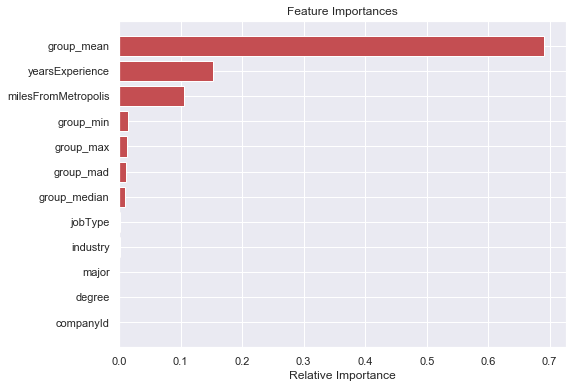

In [24]:
lr = LinearRegression()

rfr = RandomForestRegressor(n_estimators=60, n_jobs=num_procs, max_depth=15, min_samples_split=80, \
                                       max_features=8, verbose=verbose_lvl)

gboost = GradientBoostingRegressor(n_estimators=40, max_depth=7, loss='ls', verbose=verbose_lvl)

models = [lr, rfr, gboost]

model_output = ModelEvaluation(data, models)

# Part 4 - DEPLOY

Here for now, we'll just save prediction and model files, in anticipation of automating pipeline, actual deployment of solution and tests/measuring eficacy of the model

In [25]:
# Saving the submission file using the Best model
sub_file = './submission/Salary_Prediction.csv'
model_output.save_results(sub_file,model_output.test_df)


Saving the predictions to a CSV file


In [26]:
# Saving the Best model to a file.
model_file = './model/Salary_Prediction_Best_Model.sav'
model_output.save_best_model(model_file, model_output.best_model)


Saving the Best Model to a file
